In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from timm.models.vision_transformer import PatchEmbed
from einops import rearrange

/Users/michaelfyy/miniconda3/envs/DiT/lib/python3.14/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [116]:
sequence_length = 3
hidden_dim = 4

pe = torch.Tensor(sequence_length, hidden_dim)
for i in range(hidden_dim):
    if (i % 2 == 0):
        pe[:,i] = torch.sin(torch.arange(0, sequence_length) / (10000**(i/hidden_dim)))
    else:
        pe[:,i] = torch.cos(torch.arange(0, sequence_length) / (10000**((i-1)/hidden_dim)))

pe

tensor([[ 0.0000,  1.0000,  0.0000,  1.0000],
        [ 0.8415,  0.5403,  0.0100,  0.9999],
        [ 0.9093, -0.4161,  0.0200,  0.9998]])

In [117]:
class Patchify(nn.Module):
    def __init__(
        self, 
        p=4, 
        d=768,
        img_size=32,
        in_chans=4,
    ):
        super().__init__()
        self.p = p
        self.d = d
        self.img_size = img_size
        self.in_chans = in_chans

    def get_positional_embedding(self, x): # x.shape = torch.Size[(B, T, D)]
        sequence_length = x.shape[-2]
        hidden_dim = x.shape[-1]

        positional_embedding = torch.Tensor(sequence_length, hidden_dim)
        for i in range(hidden_dim):
            if (i % 2 == 0):
                positional_embedding[:,i] = torch.sin(torch.arange(0, sequence_length) / (10000**(i/hidden_dim)))
            else:
                positional_embedding[:,i] = torch.cos(torch.arange(0, sequence_length) / (10000**((i-1)/hidden_dim)))

        return positional_embedding

    def forward(self, x): # x.shape = torch.Size[(B, 4, 32, 32)] (B, C, H, W)

        # patch embed
        patch_embedder = PatchEmbed(img_size=self.img_size, patch_size=self.p, in_chans=self.in_chans, embed_dim=self.d)
        x = patch_embedder(x)

        # add positional encoding
        positional_embedding = self.get_positional_embedding(x)
        x += positional_embedding

        return x
    

class Time_Embedder(nn.Module):
    def __init__(
            self,
            embedding_dim=768,
            frequency=256,
    ):
        super().__init__()
        self.frequency = frequency
        self.embedding_dim = embedding_dim
        self.mlp = nn.Sequential(
            nn.Linear(frequency, embedding_dim),
            nn.SiLU(),
            nn.Linear(embedding_dim, embedding_dim)
        )
    
    def timestep_embedding(self, t, dim, max_period=10000):
        """
        Create sinusoidal timestep embeddings.
        :param t: a 1-D Tensor of N indices, one per batch element.
                          These may be fractional.
        :param dim: the dimension of the output.
        :param max_period: controls the minimum frequency of the embeddings.
        :return: an (N, D) Tensor of positional embeddings.
        """
        # https://github.com/openai/glide-text2im/blob/main/glide_text2im/nn.py
        half = dim // 2
        freqs = torch.exp(
            -math.log(max_period) * torch.arange(start=0, end=half, dtype=torch.float32) / half
        ).to(device=t.device)
        args = t[:, None].float() * freqs[None]
        embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
        if dim % 2:
            embedding = torch.cat([embedding, torch.zeros_like(embedding[:, :1])], dim=-1)
        return embedding

    def forward(self, x):
        x = self.timestep_embedding(x, self.frequency)
        x = self.mlp(x)
        return x


class Label_Embedder(nn.Module):
    def __init__(
            self,
            num_classes=1000,
            embedding_dim=768,
    ):
        super().__init__()
        self.embedding = nn.Embedding(num_classes, embedding_dim)
        self.num_clases = num_classes

    def forward(self, x):
        return self.embedding(x)
    

class DiT_Block_Base(nn.Module): # like in-context but no conditioning
    def __init__(
        self,
        embedding_dim=768,
        num_heads=12
    ):
        super().__init__()

        self.embedding_dim = embedding_dim
        self.num_heads = num_heads

        self.norm1 = nn.LayerNorm(embedding_dim)
        self.norm2 = nn.LayerNorm(embedding_dim)
        self.mha = nn.MultiheadAttention(embedding_dim, num_heads, batch_first=True)

        self.pointwise_mlp = nn.Sequential(
            nn.Linear(embedding_dim, embedding_dim * 4),
            nn.GELU(),
            nn.Linear(embedding_dim * 4, embedding_dim)
        )
          
    def forward(self, x):
        residual = x

        x = self.norm1(x)
        attn_output, attn_weights = self.mha(x, x, x)
        x = residual + attn_output

        residual = x
        x = self.norm2(x)
        x = residual + self.pointwise_mlp(x)

        return x
        

class DiT_Base(nn.Module):
    def __init__(
            self,
            embedding_dim=768,
            num_heads=12,
            patch_size=4,
            n_blocks=28,
            num_classes=1000
    ):
        super().__init__()  

        self.embedding_dim = embedding_dim
        self.num_heads = num_heads
        self.patch_size = patch_size

        self.patchifier = Patchify(p=self.patch_size, d=embedding_dim)
        self.time_embedder = Time_Embedder(embedding_dim=embedding_dim)
        self.label_embedder = Label_Embedder(embedding_dim=embedding_dim)
        self.dit_blocks = nn.ModuleList([
            DiT_Block_Base(embedding_dim=embedding_dim, num_heads=num_heads) for _ in n_blocks
        ])

    def forward(self, x, time, label): # x.shape = torch.Size[(B, 4, 32, 32)] (B, C, H, W)
        patch_embedding = self.patchifier(x)
        time_embedding = self.time_embedder(time)
        label_embedding = self.label_embedder(label)

        tokens = torch.cat([patch_embedding, time_embedding, label_embedding], dim=1)



In [138]:
t_embedder = Time_Embedder(embedding_dim=768, frequency=256)
y_embedder = Label_Embedder()
patch_embedder = Patchify()

t = torch.Tensor([0, 1, 2, 3, 4])
t_embedding = t_embedder(t)

label = torch.tensor([0, 0, 0, 0, 0])
y_embedding = y_embedder(label)

z = torch.rand(5, 4, 32, 32)
z_embedding = patch_embedder(z)

tokens = torch.cat([z_embedding, t_embedding.unsqueeze(1), y_embedding.unsqueeze(1)], dim=1)

block = DiT_Block_Base()

block(tokens).shape

t_embedding.shape

torch.Size([5, 768])

In [119]:
output = tokens[:, :-2, :]

In [129]:
linear = nn.Linear(768, 4*4*2*4)
linear_out = linear(output)
linear_out.shape

final_out = rearrange(linear_out, 'b (h w) (p1 p2 c) -> b c (h p1) (w p2)', p1=4, p2=4, h=32//4, w=32//4)
final_out.shape

torch.Size([5, 8, 32, 32])

In [132]:
import math
import torch
import torch.nn as nn
from torch.nn import functional as F
from timm.models.vision_transformer import PatchEmbed
from einops import rearrange


class Patchify(nn.Module):
    def __init__(
        self, 
        p=4, 
        d=768,
        img_size=32,
        in_chans=4,
    ):
        super().__init__()
        self.p = p
        self.d = d
        self.img_size = img_size
        self.in_chans = in_chans

    def get_positional_embedding(self, x): # x.shape = torch.Size[(B, T, D)]
        sequence_length = x.shape[-2]
        hidden_dim = x.shape[-1]

        positional_embedding = torch.Tensor(sequence_length, hidden_dim)
        for i in range(hidden_dim):
            if (i % 2 == 0):
                positional_embedding[:,i] = torch.sin(torch.arange(0, sequence_length) / (10000**(i/hidden_dim)))
            else:
                positional_embedding[:,i] = torch.cos(torch.arange(0, sequence_length) / (10000**((i-1)/hidden_dim)))

        return positional_embedding

    def forward(self, x): # x.shape = torch.Size[(B, 4, 32, 32)] (B, C, H, W)

        # patch embed
        patch_embedder = PatchEmbed(img_size=self.img_size, patch_size=self.p, in_chans=self.in_chans, embed_dim=self.d)
        x = patch_embedder(x)

        # add positional encoding
        positional_embedding = self.get_positional_embedding(x)
        x += positional_embedding

        return x
    

class Time_Embedder(nn.Module):
    def __init__(
            self,
            embedding_dim=768,
            frequency=256,
    ):
        super().__init__()
        self.frequency = frequency
        self.embedding_dim = embedding_dim
        self.mlp = nn.Sequential(
            nn.Linear(frequency, embedding_dim),
            nn.SiLU(),
            nn.Linear(embedding_dim, embedding_dim)
        )
    
    def timestep_embedding(self, t, dim, max_period=10000):
        """
        Create sinusoidal timestep embeddings.
        :param t: a 1-D Tensor of N indices, one per batch element.
                          These may be fractional.
        :param dim: the dimension of the output.
        :param max_period: controls the minimum frequency of the embeddings.
        :return: an (N, D) Tensor of positional embeddings.
        """
        # https://github.com/openai/glide-text2im/blob/main/glide_text2im/nn.py
        half = dim // 2
        freqs = torch.exp(
            -math.log(max_period) * torch.arange(start=0, end=half, dtype=torch.float32) / half
        ).to(device=t.device)
        args = t[:, None].float() * freqs[None]
        embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
        if dim % 2:
            embedding = torch.cat([embedding, torch.zeros_like(embedding[:, :1])], dim=-1)
        return embedding

    def forward(self, x):
        x = self.timestep_embedding(x, self.frequency)
        x = self.mlp(x)
        return x


class Label_Embedder(nn.Module):
    def __init__(
            self,
            num_classes=1000,
            embedding_dim=768,
    ):
        super().__init__()
        self.embedding = nn.Embedding(num_classes, embedding_dim)
        self.num_clases = num_classes

    def forward(self, x):
        return self.embedding(x)
    

class DiT_Block_Base(nn.Module): # like in-context but no conditioning
    def __init__(
        self,
        embedding_dim=768,
        num_heads=12
    ):
        super().__init__()

        self.embedding_dim = embedding_dim
        self.num_heads = num_heads

        self.norm1 = nn.LayerNorm(embedding_dim)
        self.norm2 = nn.LayerNorm(embedding_dim)
        self.mha = nn.MultiheadAttention(embedding_dim, num_heads, batch_first=True)

        self.pointwise_mlp = nn.Sequential(
            nn.Linear(embedding_dim, embedding_dim * 4),
            nn.GELU(),
            nn.Linear(embedding_dim * 4, embedding_dim)
        )
          
    def forward(self, x):
        residual = x

        x = self.norm1(x)
        attn_output, attn_weights = self.mha(x, x, x)
        x = residual + attn_output

        residual = x
        x = self.norm2(x)
        x = residual + self.pointwise_mlp(x)

        return x
        

class FinalLayer(nn.Module):
    def __init__(
            self,
            embedding_dim=768,
            patch_size=4,
            img_size=32,
            num_channels=4
    ):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.patch_size = patch_size
        self.img_size = img_size
        self.num_channels = num_channels
        self.norm = nn.LayerNorm(embedding_dim)
        self.linear = nn.Linear(embedding_dim, patch_size*patch_size*2*num_channels)

    def forward(self, x):
        x = self.norm(x)
        x = self.linear(x)
        x = rearrange(x, 'b (h w) (p1 p2 c) -> b c (h p1) (w p2)', 
                      p1=self.patch_size, p2=self.patch_size, h=self.img_size // self.patch_size, w=self.img_size // self.patch_size)
        return x
    

class DiT_Base(nn.Module):
    def __init__(
            self,
            embedding_dim=768,
            num_heads=12,
            patch_size=4,
            n_blocks=28,
            num_classes=1000,
            frequency=256,
            img_size=32,
            in_chans=4,
    ):
        super().__init__()  

        self.embedding_dim = embedding_dim
        self.num_heads = num_heads
        self.patch_size = patch_size
        self.num_classes = num_classes
        self.img_size = img_size
        self.in_chans = in_chans

        self.patchifier = Patchify(p=self.patch_size, d=embedding_dim, img_size=img_size, in_chans=in_chans)
        self.time_embedder = Time_Embedder(embedding_dim=embedding_dim, frequency=frequency)
        self.label_embedder = Label_Embedder(num_classes=num_classes, embedding_dim=embedding_dim)
        self.dit_blocks = nn.ModuleList([
            DiT_Block_Base(embedding_dim=embedding_dim, num_heads=num_heads) for _ in range(n_blocks)
        ])
        self.final_layer = FinalLayer(embedding_dim=embedding_dim, patch_size=patch_size, img_size=img_size, num_channels=in_chans)
        

    def forward(self, x, time, label): # x.shape = torch.Size[(B, 4, 32, 32)] (B, C, H, W)
        patch_embedding = self.patchifier(x)
        time_embedding = self.time_embedder(time)
        label_embedding = self.label_embedder(label)

        tokens = torch.cat([patch_embedding, time_embedding.unsqueeze(1), label_embedding.unsqueeze(1)], dim=1) # add conditioning tokens
        for dit_block in self.dit_blocks:
            tokens = dit_block(tokens)

        tokens = tokens[:, :-2, :] # remove conditioning tokens
        tokens = self.final_layer(tokens)
        return tokens

In [137]:
B = 16
z = torch.rand(B, 4, 32, 32)
t = torch.randint(64, (B,))
y = torch.randint(1000, (B,))
model = DiT_Base()

model(z, t, y).shape

torch.Size([16, 8, 32, 32])

In [145]:
B = 16
D = 768

z = torch.rand(B, 4, 32, 32)
t = torch.randint(64, (B,))
y = torch.randint(1000, (B,))

patch_embedder = Patchify()
z = patch_embedder(z) # (B, T, D)

gamma1 = torch.rand(B, 1, D)
beta1 = torch.rand(B, 1, D)

out = gamma1 * z + beta1
out.shape

torch.Size([16, 64, 768])

In [1]:
import torch
from models import DiT_models

model_name = 'DiT-S/2'
model = DiT_models[model_name](img_size=32, num_classes=1000)

B = 16
z = torch.rand(B, 4, 32, 32)
t = torch.randint(64, (B,))
y = torch.randint(1000, (B,))

output = model(z, t, y)
output.shape

/Users/michaelfyy/miniconda3/envs/DiT/lib/python3.14/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


torch.Size([16, 8, 32, 32])

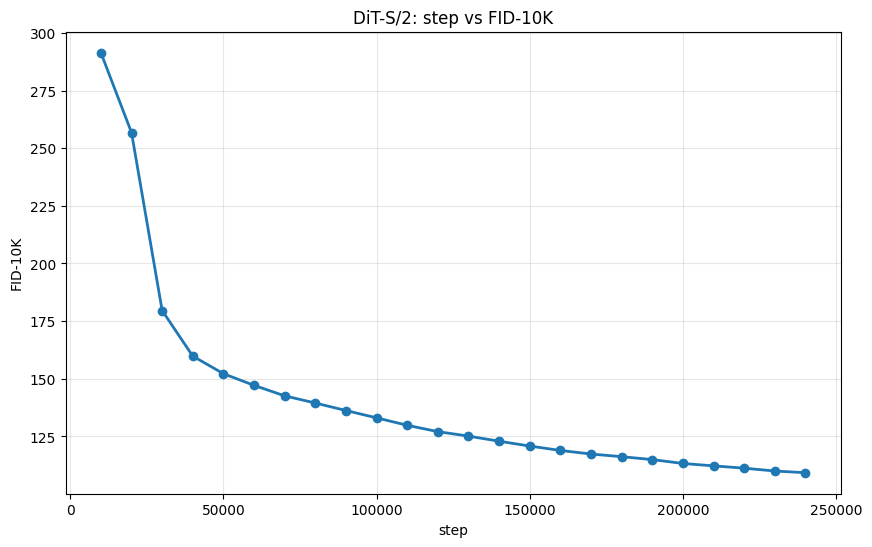

In [4]:
import pandas as pd

import matplotlib.pyplot as plt

# Load CSV file
df = pd.read_csv('fid.csv')

# Select two columns
x_col = 'step'
y_col = 'fid'

# Create scatter plot with connecting line
plt.figure(figsize=(10, 6))
plt.plot(df[x_col], df[y_col], marker='o', linestyle='-', linewidth=2, markersize=6)
plt.xlabel(x_col)
plt.ylabel('FID-10K')
plt.title(f'DiT-S/2: {x_col} vs FID-10K')
plt.grid(True, alpha=0.3)
plt.show()